# Welcome to Augmentoolkit

This notebook is where you generate all your data.

Augmentoolkit is meant to allow instruct-tuned models to learn from books, even using themselves to generate new data through a sort-of bootstrapping method. It is meant to stop model creators from having to work as data annotators, and not actual model trainers. It is meant to allow anyone to make their own high-quality dataset with thousands of entries using cheap Open-Source APIs.

## Quickstart:

- Get this notebook and the other repo code onto a machine with an internet connection
- Paste your API key, favorite model name, and the endpoint URL of your preferred AI service, into the relevant constants located in the first code cell. Recommendation: [Together.ai with Hermes Mixtral works really nicely](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO).
- Run all the cells below and watch as the notebook generates questions, answers, and conversations based on Principles of Chemistry and Simple Sabotage.

If you want to add your own texts, follow the instructions in list item #1 above.

### Note: this notebook makes roughly 1/3 characters generated to be **mildly NSFW** by default. You will need to modify the character personality code in `./generation_functions/special_instructions.py` or use "Assistant mode" if you want something cleaner.

## Customization:
### Here are some ways you can adapt this notebook to your use case, along with a brief description of how to do so, arranged in increasing order of difficulty (this information is also available in the README):
1. ***Change the source texts used to generate training data.*** You can do this in the cell right below this one. **IMPORTANT** the filenames of these should be formatted in a specific way, since the filenames are used as part of the prompts and in at least one regex. You need to have them be like: `[textname], by authorname`. You can also include the publication date after the author name if you want, but note that this will tend to bias most of the characters to live in the era of the textbook, which may or may not be what you want.

2. ***Change the personalities of the characters generated.*** Currently, when generating characters for the multiturn conversation step, three randomly-selected traits are appended to the "special instructions" set of the prompt to constrain what kind of character is generated by the model. Depending on what kind of model you want to make, or even just if your preferences vary, then you will probably want to modify this a bit. You can do so in `./generation_functions/special_instructions.py`. A more in-depth description of the trait-axis system that I (over)thought up is available in the comments of that file.

3. ***Change the constants.*** There are a few constant values in this notebook, and in `./generation_functions/constant_values.py`. These constants are tested, but if your use case requires special settings (e.g., you want to make conversations from more permutations of existing questions; or you think the character counts for the "duplicate question/answer" validation functions are too restrictive) then feel free to change the related setting. The most intuitive and least-likely-to-break-anything settings to change are rearrangements_to_take and double_check_counter. Beyond that... you'll need to figure out what the function does before changing it if you expect it to run.

4. ***Assistant Mode*** Technically this could be considered part of 3), but it's different enough that I feel it warrants separate explanation. By default, the notebook is configured to produce RP-style data; "Assistant mode" is something you can toggle in the settings cell immediately below this one, which skips character and scenario generation and answers every question in a chat between a user and a helpful AI assistant (with no personality). This can be handled by smaller models, so if your budget or time are very limited, or you are using this for a more professional use case, feel free to turn this on.

5. ***Change the model.*** This is as simple as switching the LOGICAL_MODEL value out for another one, but your mileage may vary significantly. My personal recommendation is to use [Hermes Mixtral DPO](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO) for both models. You need at least 12k context on your model, and APIs typically don't allow RoPE scaling, so you're probably limited to MistralAI models here (or, heavens forbid, OpenAI. But GPT-4.5 + Augmentoolkit will BANKRUPT you fast, so be wary).

6. ***Change the examples.*** If you change the examples you can completely overhaul what this notebook does, but this requires a lot of prompting skill and possibly huge amounts of time to get it working again (source: most of my last three months were spent prompting, and most of this prompting was spent on the examples). Unless you want to convert this notebook from question-and-answer generation to some completely other task, I'd recommend changing only the conversation generation prompts -- they're a bit less finnicky, and if you just want to change the kind of characters generated (maybe you want a different writing style) that's where you'd find the differences.



## NOTE
You will want to turn off USE_SUBSET if you are doing a proper run over an entire text. It's on by default so you can iterate faster in the preparatory stages of dataset generation (and so that you can see the magic happen faster when you first use Augmentoolkit :) )

In [1]:
# NOTE NOTEBOOK SETTINGS AND CONSTANTS (some script file constants are in generation_functions/constants.py)

# Put your desired quant of your desired model in the relevant directories

import logging

# "airoboros-l2-70b-3.1.2.Q4_K_M.gguf" <- recommended for the large logical model
# "flatorcamaid-13b-v0.2.Q8_0.gguf" <- recommended for the normal logical model
# A6000s on Vast.ai are a good choice for running this notebook

LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/FlatOrcamaid-13B-v0.2-GPTQ"  # model used for decision-making and base question generation (should be "smart")

LARGE_LOGICAL_MODEL = "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO"#"TheBloke/Airoboros-L2-70B-3.1.2-GPTQ"

ASSISTANT_MODE = False  # change to true if you want all conversations to be with an "AI language model" and not characters. Useful for more professional use cases.

DOUBLE_CHECK_COUNTER = 3  # Set to 1 to check outputs only once; set to 2 to check twice; set to 3 to check thrice, etc. Set to 0 to break everything in vet_question_loop() and elsewhere. Set to -1 and cause the universe to implode?

USE_SUBSET = True # Set to True if you want to use only a small subset of the text, to test whether it plays nicely with the current setup of the notebook

REARRANGEMENTS_TO_TAKE = 3  # How many of the possible permutations of tuples in a group to take and make multiturn convs out of. Adjust higher to get more data out of less text, but it might be a bit repetitive. NOTE your eval loss will be basically worthless if you aren't careful with how you shuffle your dataset when you're about to train.

USE_FILENAMES = False # Turn on if you want the model to use the names of your files as additional context (this is what original Augmentoolkit does). Useful if you have a small number of large input files grouped by subject matter, IE books. Turn off if you have a large number of files with meaningless names.

CONCURRENCY_LIMIT = 90  # Adjust this number based on the rate limit constraints of your api

API_KEY = "4807709e8ead3ffb0b40daaea5f361fa3c0398b99349c1b79ec94b744b1284de"

BASE_URL = "https://api.together.xyz" # Augmentoolkit-API should also be compatible with any other API provider that accepts OAI-style requests

COMPLETION_MODE=True

LOG_LEVEL = logging.INFO

source_texts = [ # add your texts here
    "./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt",
]

## Below: Defines and imports functions that you will probably use no matter what cells in the notebook you choose to run:

In [2]:
import os
import uuid

# This is in no way best practices, but all my prompts being searchable and separate files is a good way to make my life easier.
import pkgutil
import importlib
import sys
from tqdm import asyncio as tqdmasyncio
import asyncio

# Set up rate-limit-conscious functions
semaphore = asyncio.Semaphore(CONCURRENCY_LIMIT)

async def run_task_with_limit(task):
    async with semaphore:
        # Run your task here
        return await task


# We have to define this up here so that two-step generation works, you'll see later.
multi_turn_convs_info_dir = "./multi_turn_convs_info"  # we generate all the information fed to the multiturn prompt, and generate the actual multiturn prompt, separately; since every step but the last is capable of being done by a 13b

sys.path.append("./generation_functions")
sys.path.append("./control_flow_functions")

import augmentoolkit.generation_functions as generation_functions  # This is the package directory
from augmentoolkit.control_flow_functions import control_flow_functions

# First, import all modules so they can be reloaded
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    importlib.import_module(module_name)

# Now, reload each module and import all callable attributes
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    # Reload the module
    module = importlib.reload(sys.modules[module_name])
    # Iterate through each attribute in the reloaded module
    for attribute_name in dir(module):
        # Retrieve the attribute
        attribute = getattr(module, attribute_name)
        if callable(attribute):
            # If it's callable, it's a function or class, so you set it in the globals dictionary
            globals()[attribute_name] = attribute

In [3]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [4]:
from transformers import AutoTokenizer
import re
from tqdm import tqdm
import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

tokenizer = AutoTokenizer.from_pretrained(
    "Gryphe/MythoMax-L2-13b"
)  # It doesn't matter what model goes here, really

sentence_chunks = []
for source_text in source_texts:
    sentence_chunks += control_flow_functions.sentence_chunking_algorithm(source_text, tokenizer)

conversions = [("\n", " "), ("  ", " ")]

paragraphs_processed = [
    (control_flow_functions.fix_text(conversions, seq[0]), seq[1]) for seq in sentence_chunks
]

[nltk_data] Downloading package punkt to /Users/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Processing ./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt: 100%|██████████| 603/603 [00:00<00:00, 13647.12it/s]


#### Inspect various features of the text you have fed in to see if it came out alright-ish

In [5]:
len(paragraphs_processed)

52

In [6]:
paragraphs_processed[0]

('\ufeffThe Project Gutenberg eBook of Simple Sabotage Field Manual   This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Simple Sabotage Field Manual  Author: United States. Office of Strategic Services Release date: August 4, 2008 [eBook #26184]         Most recently updated: February 28, 2022 Language: English    [Illustration]   Simple Sabotage Field Manual Office of Strategic Services   OSS REPRODUCTION BRANCH SIMPLE SABOTAGE FIELD MANUAL Strategic Services (Provisional) STRATEGIC SERVICES FIELD MANUAL No. 3   Office of Strategic Services Washington, D. C. 17 January 1944  This Simple Sabot

In [7]:
import json
import os
from tqdm import tqdm
import asyncio

# Create directory if it doesn't exist
output_dir = "./worthy_for_questions"
os.makedirs(output_dir, exist_ok=True)

# Determine which paragraphs are worthy of making questions from
judged_worthy_for_questions = []

await control_flow_functions.filter_all_questions(paragraphs_processed, judged_worthy_for_questions, engine_wrapper, output_dir, take_subset=USE_SUBSET, use_filenames=True, rtwl=run_task_with_limit, completion_mode=COMPLETION_MODE,logging_level=LOG_LEVEL)

100%|██████████| 13/13 [00:00<00:00, 7004.88it/s]

LOADING:  {'paragraph': 'An effort should be made to add to their efficiency, lessen their detectability, and increase their number. Acts of simple sabotage, multiplied by thousands of citizen-saboteurs, can be an effective weapon against the enemy. Slashing tires, draining fuel tanks, starting fires, starting arguments, acting stupidly, short-circuiting electric systems, abrading machine parts will waste materials, manpower, and time. Occurring on a wide scale, simple sabotage will be a constant and tangible drag on the war effort of the enemy. Simple sabotage may also have secondary results of more or less value. Widespread practice of simple sabotage will harass and demoralize enemy administrators and police. Further, success may embolden the citizen-saboteur eventually to find colleagues who can assist him in sabotage of greater dimensions. Finally, the very practice of simple sabotage by natives in enemy or occupied territory may make these individuals identify themselves actively

/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py:1021: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


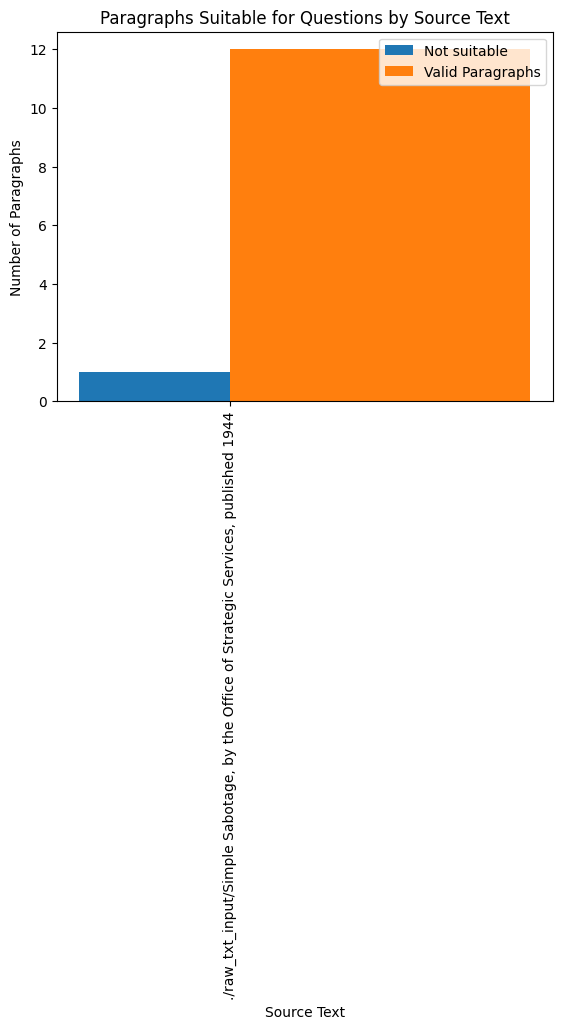

In [8]:
filtered_worthy_for_questions = control_flow_functions.filter_and_graph(judged_worthy_for_questions)

In [9]:
print(filtered_worthy_for_questions[0])

('An effort should be made to add to their efficiency, lessen their detectability, and increase their number. Acts of simple sabotage, multiplied by thousands of citizen-saboteurs, can be an effective weapon against the enemy. Slashing tires, draining fuel tanks, starting fires, starting arguments, acting stupidly, short-circuiting electric systems, abrading machine parts will waste materials, manpower, and time. Occurring on a wide scale, simple sabotage will be a constant and tangible drag on the war effort of the enemy. Simple sabotage may also have secondary results of more or less value. Widespread practice of simple sabotage will harass and demoralize enemy administrators and police. Further, success may embolden the citizen-saboteur eventually to find colleagues who can assist him in sabotage of greater dimensions. Finally, the very practice of simple sabotage by natives in enemy or occupied territory may make these individuals identify themselves actively with the United Nation

### The cell below begins generating questions. SOME OF THESE MAY FAIL and have to retry due to model errors (the API branch cannot use grammars). But if you let it run you will see that the vast majority eventually get through.

In short, don't get scared by tracebacks.

In [10]:
# control flow
import json
import os
import glob

# Directory for QA tuples
qa_tuples_dir = "./qatuples_raw"
if not os.path.exists(qa_tuples_dir):
    os.makedirs(qa_tuples_dir)

# Initialize vetted_qa_tuples
vetted_qa_tuples = []  # tuple list of qa tuples that have been judged good

# Attempt to initialize filtered_worthy_for_questions
try:
    _ = filtered_worthy_for_questions
except NameError:
    filtered_worthy_for_questions = []

if not filtered_worthy_for_questions:
    # Load all files in the qa_tuples_dir if filtered_worthy_for_questions is not initialized
    existing_files = glob.glob(os.path.join(qa_tuples_dir, "*.json"))
    for file_path in existing_files:
        with open(file_path, "r") as file:
            qa_tuple = tuple(json.load(file))
            print(f"Loaded {file}")
        vetted_qa_tuples.append(qa_tuple)
else:
    tasks = [control_flow_functions.generate_qatuples_from_para(
        idx,
        para,
        engine_wrapper=engine_wrapper,
        vetted_qa_tuples=vetted_qa_tuples,
        qa_tuples_dir=qa_tuples_dir,
        double_check_counter=DOUBLE_CHECK_COUNTER,
        use_filenames=USE_FILENAMES,
        completion_mode=COMPLETION_MODE,
        logging_level=LOG_LEVEL) for idx,para in enumerate(filtered_worthy_for_questions)]
    limited_tasks_qgen = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qgen):
            await future
    

100%|██████████| 12/12 [00:00<00:00, 2341.01it/s]

Skipping para_4 as files already exist; loading said files
Skipping para_0 as files already exist; loading said files
Skipping para_8 as files already exist; loading said files
Skipping para_11 as files already exist; loading said files
Skipping para_7 as files already exist; loading said files
Skipping para_10 as files already exist; loading said files
Skipping para_1 as files already exist; loading said files
Skipping para_5 as files already exist; loading said files
Skipping para_2 as files already exist; loading said files
Skipping para_6 as files already exist; loading said files
Skipping para_9 as files already exist; loading said files
Skipping para_3 as files already exist; loading said files


In [11]:
print(
    "-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):"
)
nones = list(filter(lambda x: x[0] is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa[0] is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):
Nones: 0
Non-nones: 47
Total: 47
---------------- ONTO EXAMPLES GENERATION-------------------


In [12]:
# Check for and fix the common mistake: mentioning "the text".
writepath = "./qatuples_revised"
import json

# Assuming vetted_qa_tuples is a list that might or might not exist
try:
    _ = vetted_qa_tuples
except NameError:
    vetted_qa_tuples = []

# Load all files at the start if vetted_qa_tuples is empty
if not vetted_qa_tuples:
    # Check if the directory exists
    if os.path.exists(writepath):
        # List all files in directory
        for file_name in os.listdir(writepath):
            file_path = os.path.join(writepath, file_name)
            try: # for each file already generated, see if it succeeded or failed; if it succeeded, append its contents; if it failed, append None for stats logging
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    print(f"Loading file: {file_path}")
                    if content == "failed":
                        vetted_qa_tuples.append(None)
                    else:
                        try:
                            data = json.loads(content)
                            vetted_qa_tuples.append(
                                (data[0], data[1], data[2], data[3])
                            )
                        except json.JSONDecodeError:
                            print("JSON decode error with the contents:", content)
                            vetted_qa_tuples.append(None)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

else:
    old_tuples = vetted_qa_tuples.copy()
    tasks = [control_flow_functions.repair_qatuple_context(idx, tup, engine_wrapper, writepath, vetted_qa_tuples,use_filenames=USE_FILENAMES) for idx, tup in enumerate(vetted_qa_tuples)]
    limited_tasks_qcorrection = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qcorrection): 
        await future

100%|██████████| 47/47 [00:00<00:00, 16096.37it/s]

./qatuples_revised/revised_13.json
Loaded file:
[
    "What are some forms of simple sabotage that can be performed by citizen-saboteurs?",
    "Simple sabotage acts include slashing tires, draining fuel tanks, starting fires, starting arguments, acting stupidly, short-circuiting electric systems, and abrading machine parts.",
    "An effort should be made to add to their efficiency, lessen their detectability, and increase their number. Acts of simple sabotage, multiplied by thousands of citizen-saboteurs, can be an effective weapon against the enemy. Slashing tires, draining fuel tanks, starting fires, starting arguments, acting stupidly, short-circuiting electric systems, abrading machine parts will waste materials, manpower, and time. Occurring on a wide scale, simple sabotage will be a constant and tangible drag on the war effort of the enemy. Simple sabotage may also have secondary results of more or less value. Widespread practice of simple sabotage will harass and demoralize en

In [13]:
# Print stats related to revised qatuples, and filter out nones (questions that were unanswerable due to lack of context).
import json
import os

print("-------------- QUESTIONS REVISED ------------- STATS SO FAR:")
nones = list(filter(lambda x: x is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS REVISED ------------- STATS SO FAR:
Nones: 6
Non-nones: 41
Total: 47
---------------- ONTO EXAMPLES GENERATION-------------------


In [14]:
qa_tuples_by_paragraph = control_flow_functions.group_by_text(vetted_qa_tuples)

In [15]:
import os

if not os.path.exists(multi_turn_convs_info_dir):
    os.makedirs(multi_turn_convs_info_dir)

In [16]:
import json
import random
import itertools

multi_turn_convs_info = []


tasks = [control_flow_functions.create_info(idx,group,engine_wrapper, ASSISTANT_MODE, multi_turn_convs_info,multi_turn_convs_info_dir, rearrangements_to_take=REARRANGEMENTS_TO_TAKE,use_filenames=USE_FILENAMES, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,group in enumerate(qa_tuples_by_paragraph)]
limited_tasks_infocreation = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_infocreation):
    await future

100%|██████████| 12/12 [00:00<00:00, 5882.61it/s]

Skipped generating ./multi_turn_convs_info/info_1_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_1_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_5_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_5_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_5_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_11_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_11_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_11_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_10_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_10_1.json as

### No notebook restart needed for the API notebook!

### BUT You still might've separated your generations into large and small models, so we reinitialize the engine wrapper

In [17]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LARGE_LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [18]:
import os
import json

convs_info = control_flow_functions.read_json_files_info(multi_turn_convs_info_dir)

In [19]:
import os
import json
import random
import itertools
import asyncio

multi_turn_convs_dir = "./multi_turn_convs"
if not os.path.exists(multi_turn_convs_dir):
    os.makedirs(multi_turn_convs_dir)

multi_turn_convs = []

tasks = [control_flow_functions.create_conversation(idx,info, engine_wrapper, multi_turn_convs, multi_turn_convs_dir, assistant_mode=ASSISTANT_MODE, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,info in enumerate(convs_info)]
limited_tasks_convwriting = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_convwriting):
    await future

  0%|          | 0/34 [00:00<?, ?it/s]2024-02-08 05:55:32,193 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backstory?"
Elise Delacroix: "Ah!~ You're interested in me, are you?" Elise

Extracted name: Eleanor
Extracted name: Eleanor
Extracted name: Eleanor
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-02-08 05:55:32,227 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backstory?"
Elise Delacroix: "Ah!~ You're interested in me, are you?" Elise flashes a coy grin and blushes as she

Extracted name: Lila Rousseau
Extracted name: Lila Rousseau
Extracted name: Lila Rousseau
Extracted name: Vera Williams
Extracted name: Vera Williams
Extracted name: Vera Williams
Extracted name: Betsy Cromwell
Extracted name: Betsy Cromwell
Extracted name: Betsy Cromwell
Extracted name: Katherine Winthrop
Extracted name: Katherine Winthrop
Extracted name: Katherine Winthrop
Extracted name: Hanna Thompson
Extracted name: Hanna Thompson
Extracted name: Hanna Thompson
Extracted name: Ada Kensington
Extracted name: Ada Kensington
Extracted name: Ada Kensington
Extracted name: Harlow
Extracted name: Harlow
Extracted name: Harlow
Extracted name: Katherine Wellington
Extracted name: Katherine Wellington
Extracted name: Katherine Wellington
Extracted name: Violetta Ravenwood
Extracted name: Violetta Ravenwood
Extracted name: Violetta Ravenwood
Extracted name: Hilda Gundersen
Extracted name: Hilda Gundersen
Extracted name: Hilda Gundersen
Extracted name: Cynthia Watts
Extracted name: Cynthia W

2024-02-08 05:55:33,975 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,977 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,978 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,980 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,982 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,983 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,984 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,985 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,986 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 520 "
2024-02-08 05:55:33,988 - INFO - HTTP Request: POST htt

Output written to ./output/multiturn_conversation_generations/c9ec2b9b-7662-4ec7-95e4-7b8ac081dc03.txt
Answer 2: "Ah, the art of manipulation," Gideon says, his eyes gleaming with a dark excitement. "To answer your question, the feelings that should be instilled in the saboteur are those that will best serve the propagandist's goals. This could include anything from fear and anxiety to anger and hatred, depending on the desired outcome. But of course, that's just the starting point. The real challenge lies in finding the most effective way to elicit those emotions in the target audience." Gideon's lips curl into a smile, revealing a hint of the darkness that lies within him. "Now, if you'll excuse me, I have some... experiments to attend to. But I do hope you'll consider joining me in my research. I'm sure we could learn a great deal from each other." does not match the corresponding answer in qatuples: The text suggests that the citizen-saboteur should feel that they are acting in sel

2024-02-08 05:55:55,650 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:55:55,658 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/13494d8d-b639-49cf-949a-339f244b2097.txt
Answer 1: "Of course! It's always good to know how to start a fire safely. Let's start with the first method, shall we? Firefighters often use a lighter or matches to ignite a flame quickly and efficiently. It's a tried and true method that's been used for centuries. Now," Trevor reaches into his pocket and pulls out a lighter, "let's see it in action." He strikes the lighter and a small flame flickers to life. "As you can see, it's a simple and effective way to start a fire, but it's always important to be careful with an open flame, especially in a wilderness setting." does not match the corresponding answer in qatuples: To ignite more resistant materials, use a candle plus tightly rolled or twisted paper which has been soaked in gasoline., ed in gasoline.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extrac

2024-02-08 05:55:56,327 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:55:56,331 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/82ad0245-61a6-47ca-9faa-02f1258650aa.txt
Answer 1: "I-I-I'm so sorry if I seem nervous, Jake. It's just that I-I'm not used to being approached by students after class. Um... an ignition method is a way to initiate a chemical reaction by providing the necessary energy to start it," Vera says, her voice shaking slightly. "There are several different methods, including using a spark or a flame, or even applying pressure or heat. I must stress, however, that these methods can be dangerous if not handled properly. So please be careful if you decide to conduct any experiments on your own." does not match the corresponding answer in qatuples: The first type of fuse suggested is simple, made by soaking one end of a piece of string in grease, then applying a pinch of gunpowder to the cross-section where grease-soaked string meets clean string. When this ignites, the string will burn slowly and without a flame until it reaches the gr

2024-02-08 05:55:59,768 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:55:59,771 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/b7c577ec-1e42-4d77-b92b-92b796caf4ca.txt
Answer 1: "Aims and methods of sabotage, Emily?" Alicia's smile falters, replaced by a stern frown as she looks at the younger librarian. "While I appreciate your curiosity, I must say that such subjects are not appropriate for a library. However," Alicia's voice softens a bit, "since you've asked, I suppose I can provide you with some basic information on the matter." Alicia frowns again, as if disapproving of her own words. "The aims of sabotage are to disrupt, delay, or destroy an enemy's efforts, be they military, economic, or political. As for the methods, well, there are many ways to carry out such acts, including breaking equipment, spreading false information, or even assassination. I would suggest, however, that you turn your attention to more uplifting subjects." does not match the corresponding answer in qatuples: Simple sabotage should consist of acts whose results will be

2024-02-08 05:56:01,569 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:01,575 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/88f22c73-6ea9-47c0-8421-e9bc8e43df9e.txt
Answer 1: "Sabotage, you say? Ah, yes, a topic that is indeed troubling. But before we delve too deep into the topic, let us first seek guidance from our Lord and Savior. As the Good Book says, 'Thou shalt not steal.' Sabotage is a form of theft, is it not? Taking away that which does not belong to us. It is a sin against God and our fellow man. Therefore, I must say that I do not condone such actions. They are contrary to the values of our community and the virtues of our faith." does not match the corresponding answer in qatuples: Citizen saboteurs should target critical materials, valuable in themselves or necessary to the efficient functioning of transportation and communication. These may include oil, gasoline, tires, food, and water., ood, and water.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracte

2024-02-08 05:56:04,047 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:04,053 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/a04f2c78-edf9-4d52-abd3-095d11a88e8a.txt
Answer 2: "Ah, the publishing of the text!" Uriah laughs, his eyes twinkling with malicious delight. "Now that's a story that's worth telling. You see, the text was smuggled out of the occupied territory by a brave group of resistance fighters. They risked their lives to get the information to the outside world, to let people know what was really going on. And once it was out there, it spread like wildfire. People were hungry for the truth, and they were willing to do whatever it took to get it. And as for who was behind it? Well, that's a bit of a mystery, isn't it? Some say it was the work of a lone dissident, others say it was a coordinated effort by the entire resistance movement. But one thing is for sure: the text had a massive impact, and it changed the course of history. Just thinking about it makes me want to... well, you know." Uriah laughs again, his voice low and dangerous

2024-02-08 05:56:09,704 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:09,706 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/b58c257e-43f0-4370-82e2-4a066d47d048.txt
Answer 3: "O-oh, um, well," Eleanor blushes, shifting uncomfortably in her seat. "Um, simple sabotage is carried out by... by taking small, seemingly insignificant actions that have a cumulative effect over time. Um, it... it can involve things like leaving equipment in a state of disrepair, or spreading false rumors, or... or deliberately working slowly and inefficiently. Um, it's like... like a... a thousand paper cuts that eventually add up to something much bigger. But... but don't take my word for it. I'm just a simple librarian, after all." does not match the corresponding answer in qatuples: Simple sabotage, practiced on a wide scale by thousands of citizen-saboteurs, could become a constant and tangible drag on the enemy's war effort., y's war effort.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extra

2024-02-08 05:56:10,803 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:10,806 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/51cd70cd-7cf6-42fa-a23a-306ea1e67053.txt
Answer 3: "O-oh, um..." Jemima blushes, her face turning an even deeper shade of red. "I... I'm not sure I understand the question, exactly..." She looks down at her feet, her voice barely a whisper. "But, um, I do know that it can... can slow down the enemy's operations, and... and make it harder for them to achieve their goals. It's... it's about... about making it harder for them to, um, to do their job. It's... it's about being... about being... um, clever, I guess." She bites her lip, her eyes downcast. "I know it sounds... strange, but, um, it's actually quite... quite interesting, in a way. It's a way of... of fighting without... without being violent." does not match the corresponding answer in qatuples: According to the text, the 'human element' of non-destructive sabotage involves non-cooperative attitudes, bickerings, and surliness and stupidity, which often contribute to a

2024-02-08 05:56:11,204 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:11,207 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/82b24620-ff57-4372-9a59-eb353e21f182.txt
Answer 1: "Oh, really?" she purrs, leaning forward to give him a closer look. "What could a charming but dangerous man like yourself need from someone like me? I'll be glad to help you, if I can," she adds, her voice dripping with seduction. does not match the corresponding answer in qatuples: A government could, for instance, suggest through media channels or word of mouth that acts of sabotage have successfully disrupted enemy operations in certain areas. Even if the acts described are not applicable to a citizen's surroundings, the very knowledge of success elsewhere may inspire them to attempt similar acts., t similar acts.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Eleanor Rousseau
Extracted name: Eleanor Rousseau


2024-02-08 05:56:11,918 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
  3%|▎         | 1/34 [00:39<21:51, 39.73s/it]

Output written to ./output/multiturn_conversation_generations/c9ec2b9b-7662-4ec7-95e4-7b8ac081dc03.txt
Answer 1: "Propaganda, huh?" Gideon's eyes light up with a dark excitement at the mention of his favorite topic. "Well, you've come to the right place. You see, Lila," Gideon says, leaning forward and lowering his voice conspiratorially, "the best channels for the publication of propaganda are those that are unexpected and unexpectedly effective. For example, a well-placed whisper in the ear of a key figure can be more effective than a thousand leaflets dropped from the sky." Gideon chuckles darkly, his eyes glinting with a twisted sense of humor. "But enough about that. Tell me, how do you feel about joining me in my research? I could use an assistant who understands the finer points of human psychology." does not match the corresponding answer in qatuples: Statements praising the effectiveness of simple sabotage can be published by white radio and freedom stations., eedom stations.


2024-02-08 05:56:14,258 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:14,262 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/29881251-5f3f-4086-a7fb-4561b5ec7df7.txt
Answer 1: "Mmmm, such an innocent question," Dahlia coos, her voice low and sultry as she leans forward, her long black hair cascading over her shoulders like a cloak of darkness. "Sabotage, my dear, is the art of undermining or destroying an opponent's plans or efforts. It is a powerful tool in the hands of those who know how to wield it." She chuckles softly, her eyes locking onto James with an intensity that is both mesmerizing and terrifying. "And believe me, I am very, very good at it." She leans back, her hooded robe draping over her body like a cloak of darkness. "And why do you ask, my dear? Are you interested in joining our little family?" does not match the corresponding answer in qatuples: The text encourages saboteurs to attack facilities that can be used by the authorities to transmit instructions or morale material, which includes telephone, telegraph and power systems, 

2024-02-08 05:56:16,477 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:16,486 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/71c8bc55-6063-4271-af07-f33a865fac58.txt
Answer 1: "Well, alright then." Betsy replies, her voice filled with caution and wariness. "I suppose we can get started, but I hope you understand that some topics are simply not... appropriate for a young lady like yourself to be discussing. Now, what's this concept you're struggling with?" does not match the corresponding answer in qatuples: The practice of simple sabotage can harass and demoralize enemy administrators and police., ors and police.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Betsy Gaines
Extracted name: Betsy Gaines


2024-02-08 05:56:26,192 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
  6%|▌         | 2/34 [00:54<13:12, 24.76s/it]

Output written to ./output/multiturn_conversation_generations/82ad0245-61a6-47ca-9faa-02f1258650aa.txt
Answer 1: "Of course, Jake," Vera replies, her voice trembling slightly as she speaks. "I-It's always a pleasure to help my students understand the material better. Now, the first question I believe you have is: What are the different methods of chemical ignition?" does not match the corresponding answer in qatuples: The first type of fuse suggested is simple, made by soaking one end of a piece of string in grease, then applying a pinch of gunpowder to the cross-section where grease-soaked string meets clean string. When this ignites, the string will burn slowly and without a flame until it reaches the grease and gunpowder, where it will flare up suddenly. The second type of fuse suggested makes use of matches instead of grease and gunpowder; the string is simply run over match heads, and the same effect will be achieved. The advantage of both fuses is that string burns at a set speed

2024-02-08 05:56:28,339 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:28,346 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/463b3651-1e31-4879-ae2b-4895ffb13b1e.txt
Answer 1: "Oh... um... well... uh... I... I... can't really say... uh... I... I... don't know much about... uh... materials... or... uh... tools... or... uh... anything like that... uh... I... I... just... uh... read... uh... the Bible... and... uh... try... uh... to... uh... live my life... uh... according to its teachings... uh... but... uh... I... I... heard... uh... some people... uh... use... uh... chemicals... or... uh... explosives... or... uh... fire... to... uh... sabotage... things... uh... I... I... don't... uh... know if... uh... it's... uh... sinful... or... uh... wrong... but... uh... it... it... sounds... uh... dangerous... and... uh... destructive... to me... uh... anyway... um... I... I... I... uh..." does not match the corresponding answer in qatuples: Some strategies include using materials that appear innocent, committing acts for which large numbers of people coul

2024-02-08 05:56:29,132 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:29,138 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/7ca6bc64-be29-4380-a2ef-baf75cb52c53.txt
First question does not contain a part of the question from tuples. Validation failed!
----------------



RETRYING!!!!



----------------
Extracted name: Hilda Gundersen
Extracted name: Hilda Gundersen


2024-02-08 05:56:31,886 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
  9%|▉         | 3/34 [00:59<08:17, 16.05s/it]

Output written to ./output/multiturn_conversation_generations/13494d8d-b639-49cf-949a-339f244b2097.txt
Answer 1: "Well, it's always nice to meet a curious mind," Trevor replies, his deep voice resonating throughout the fire station. "Let's start with the first method we use to ignite flames in an emergency situation: using a fire starter. A fire starter is a small, cylindrical tool that has a rod of magnesium on one end and a piece of flint on the other. To use it, you strike the flint against the magnesium rod, causing sparks to fly. These sparks ignite tinder, which is a small amount of highly flammable material like dry leaves or grass. Once the tinder is lit, you can add larger pieces of fuel to the fire, like twigs or branches." does not match the corresponding answer in qatuples: To ignite more resistant materials, use a candle plus tightly rolled or twisted paper which has been soaked in gasoline., ed in gasoline.
Answers in dialogues do not match corresponding answers in qatupl

2024-02-08 05:56:32,721 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:56:32,724 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/e721db78-feb2-40d7-838c-39464f93a972.txt
Answer 1: "The work I do?" Brent snorts derisively, his eyes narrowing suspiciously as he folds his arms across his chest. "You mean the work that I'm not allowed to talk about with anyone who doesn't have the proper clearance? You mean the work that could get me thrown in prison if I'm not careful?" does not match the corresponding answer in qatuples: Simple sabotage does not require specially prepared tools or equipment, it can be executed by an ordinary citizen without the necessity for active connection with an organized group, and it is carried out in such a way as to involve a minimum danger of injury, detection, and reprisal., , and reprisal.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Brent Miller
Extracted name: Brent Miller


2024-02-08 05:56:40,012 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 12%|█▏        | 4/34 [01:07<06:27, 12.92s/it]

Output written to ./output/multiturn_conversation_generations/88f22c73-6ea9-47c0-8421-e9bc8e43df9e.txt
Answer 1: "Sabotage, you say?" Katherine's voice is soft, but there's a hint of disapproval in her tone. "I must confess, that is not a topic I am familiar with, as we are a peaceful community. But let us delve into it, as I am always eager to learn. You see, Thomas, the Bible teaches us that we must always act with righteousness and integrity, even in times of great turmoil. To resort to sabotage is to act with deceit and dishonesty, which is not the way of the Lord." Katherine then quotes from the Bible, "Do not be overcome by evil, but overcome evil with good." does not match the corresponding answer in qatuples: Citizen saboteurs should target critical materials, valuable in themselves or necessary to the efficient functioning of transportation and communication. These may include oil, gasoline, tires, food, and water., ood, and water.
Answers in dialogues do not match correspondi

2024-02-08 05:56:42,099 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 15%|█▍        | 5/34 [01:09<04:21,  9.01s/it]

Output written to ./output/multiturn_conversation_generations/51cd70cd-7cf6-42fa-a23a-306ea1e67053.txt
Answer 2: "I-I don't know much about it, but..." Jemima's voice quivers as she struggles to find the right words. "I think some examples might include... changing a schedule, misplacing important documents, or creating confusion or misinformation. These things don't cause any physical damage, but they can still be very effective at disrupting someone's activities." Jemima's eyes dart around nervously, her heart pounding in her chest. does not match the corresponding answer in qatuples: The non-destructive method of sabotage that involves making faulty decisions, adopting a non-cooperative attitude, and inducing others to follow suit is the second type of simple sabotage., imple sabotage.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:56:45,369 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 18%|█▊        | 6/34 [01:13<03:17,  7.06s/it]

Output written to ./output/multiturn_conversation_generations/29881251-5f3f-4086-a7fb-4561b5ec7df7.txt
Answer 1: "Sabotage, hmm? How... intriguing." Dahlia purrs, her voice dripping with lust as she slowly saunters towards James. "I can help you with that, my dear, but you must be willing to do anything I say." She leans in close, her lips brushing against James' ear as she whispers, "Now, let's start with the basics. What is sabotage?" does not match the corresponding answer in qatuples: The text encourages saboteurs to attack facilities that can be used by the authorities to transmit instructions or morale material, which includes telephone, telegraph and power systems, radio, newspapers, placards, and public notices., public notices.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:56:45,780 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 21%|██        | 7/34 [01:13<02:11,  4.89s/it]2024-02-08 05:56:45,880 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/b58c257e-43f0-4370-82e2-4a066d47d048.txt
Answer 2: "Um, well, according to this book, some examples include, um, deliberately misplacing or losing important documents, spreading false rumors or gossip, or even, um, sabotaging equipment in subtle ways. But... but it's all meant to be, um, subtle. So that, um, the people doing it can, um, avoid detection." Eleanor blushes again, looking down at her hands and fiddling with a pen she had on her desk. does not match the corresponding answer in qatuples: The practice of simple sabotage can harass and demoralize enemy administrators and police., ors and police.
Answers in dialogues do not match corresponding answers in qatuples.
Output written to ./output/multiturn_conversation_generations/a04f2c78-edf9-4d52-abd3-095d11a88e8a.txt
Answer 2: "Ah, the publication of the text. Now that's a juicy story. You see, we had to be very careful with how we disseminated the information. We coul

2024-02-08 05:56:46,627 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 26%|██▋       | 9/34 [01:14<01:08,  2.73s/it]

Output written to ./output/multiturn_conversation_generations/b7c577ec-1e42-4d77-b92b-92b796caf4ca.txt
Answer 1: "Sabotage, you say?" Alicia's face hardens into a stern frown. "I must say, I'm rather surprised to hear you asking about such a topic, Emily. It's a rather unsavory subject, but I suppose there's no harm in educating oneself on the matter." She closes her eyes for a moment, as if searching her memory. "As for resources, I would recommend 'Sabotage: A Study of Industrial Sabotage' by John King. It's a bit outdated, but it should give you a good overview of the aims and methods of sabotage." does not match the corresponding answer in qatuples: Simple sabotage should consist of acts whose results will be detrimental to the materials and manpower of the enemy., r of the enemy.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:56:49,119 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 29%|██▉       | 10/34 [01:16<01:04,  2.67s/it]

Output written to ./output/multiturn_conversation_generations/82b24620-ff57-4372-9a59-eb353e21f182.txt
Answer 1: "Simple sabotage? Oh, mon cheri!" Eleanor coquettishly raises an eyebrow and leans closer to Pierre, her perfume wafting through the air as she whispers seductively, "I may not be an expert on warfare, but I do know a thing or two about... subverting expectations, shall we say? And I think I can help you with that." She flashes a coy smile, her eyes twinkling with mischief. "You see, the key to any successful sabotage is to make it look like an accident, or to make it seem like it was done by someone else entirely. Now, isn't that a sexy thought?" does not match the corresponding answer in qatuples: A government could, for instance, suggest through media channels or word of mouth that acts of sabotage have successfully disrupted enemy operations in certain areas. Even if the acts described are not applicable to a citizen's surroundings, the very knowledge of success elsewher

2024-02-08 05:56:51,871 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 32%|███▏      | 11/34 [01:19<01:01,  2.69s/it]

Output written to ./output/multiturn_conversation_generations/71c8bc55-6063-4271-af07-f33a865fac58.txt
Answer 4: "Well, I'm glad to hear that," Betsy says, visibly relieved. "I don't like to think about such things, but I suppose it's important to understand our history, even if it's a bit... unsettling. Now, before we continue with our lunch break, I just want to remind you to always strive for goodness and honesty in your life. Those are the values that will truly make a difference in the world." does not match the corresponding answer in qatuples: Simple sabotage, practiced on a wide scale by thousands of citizen-saboteurs, could become a constant and tangible drag on the enemy's war effort., y's war effort.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:56:53,360 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 35%|███▌      | 12/34 [01:21<00:51,  2.36s/it]

Output written to ./output/multiturn_conversation_generations/e721db78-feb2-40d7-838c-39464f93a972.txt
Answer 1: "AR 380-5," Brent begins, his eyes darting around nervously as he speaks. "P-Pertains to handling of secret documents. It is a highly classified document, and it is not to be discussed with anyone who does not have the proper clearance." He pauses, his eyes narrowing as he looks at Sarah. "But... but you're not supposed to know about this, okay? You... you can't tell anyone. I... I don't want to get in trouble." does not match the corresponding answer in qatuples: Simple sabotage does not require specially prepared tools or equipment, it can be executed by an ordinary citizen without the necessity for active connection with an organized group, and it is carried out in such a way as to involve a minimum danger of injury, detection, and reprisal., , and reprisal.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:57:00,672 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 38%|███▊      | 13/34 [01:28<01:19,  3.76s/it]

Output written to ./output/multiturn_conversation_generations/7ca6bc64-be29-4380-a2ef-baf75cb52c53.txt
First question does not contain a part of the question from tuples. Validation failed!


2024-02-08 05:57:04,707 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 41%|████      | 14/34 [01:32<01:16,  3.84s/it]

Output written to ./output/multiturn_conversation_generations/463b3651-1e31-4879-ae2b-4895ffb13b1e.txt
Answer 1: "O-Oh, h-heavy topics..." Wanda blushes even harder, her face now a deep shade of crimson. "Well, I-I guess I could t-try to help you out, Emily," She says, her voice barely above a whisper as she nervously fidgets with the hem of her long skirt. "A s-saboteur could use several s-strategies to disrupt their target. F-For example, they might try to d-damage their target's reputation by spreading r-rumors or gossip. Or they m-might try to physically h-harm their target by using weapons or s-sabotaging their surroundings." She looks down at her hands, fiddling with the edge of her Bible. "As for materials, a s-saboteur might use explosives, chemicals, or even biological agents to cause damage. B-But I must emphasize that these are all v-very dangerous and s-sinful acts, Emily. We should avoid them at all costs." does not match the corresponding answer in qatuples: Some strategi

2024-02-08 05:57:12,411 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
2024-02-08 05:57:12,416 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
2024-02-08 05:57:12,419 - INFO - Retrying request to /completions in 0.878441 seconds
2024-02-08 05:57:12,420 - INFO - Retrying request to /completions in 0.846634 seconds
2024-02-08 05:57:12,425 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
2024-02-08 05:57:12,427 - INFO - Retrying request to /completions in 0.849307 seconds
2024-02-08 05:57:12,447 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
2024-02-08 05:57:12,449 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
2024-02-08 05:57:12,450 - INFO - Retrying request to /completions in 0.896866 seconds
2024-02-08 05:57:12,451 - INFO - Retrying request to /completions in 0.769212 seconds
2024-02-08 05:57:12,454 - INFO - HTTP Request

Output written to ./output/multiturn_conversation_generations/729917ed-0995-483e-83f4-19227f5ea818.txt
Answer 1: "Ah, my child, the construction of the Panama Canal was indeed a remarkable feat of human ingenuity and perseverance. The workers faced many challenges, including malaria and yellow fever. These diseases took a heavy toll on the workforce, and many lives were lost as a result. However, through the tireless efforts of public health officials and medical experts, these diseases were eventually brought under control. New techniques for mosquito control were developed, and workers were provided with better housing and sanitation facilities. The lessons learned from the Panama Canal project continue to shape our approach to public health today, and I pray that they may be used to alleviate suffering and improve the lives of people around the world." does not match the corresponding answer in qatuples: A government could, for instance, suggest through media channels or word of mou

2024-02-08 05:57:36,184 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:36,189 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/d40943fa-c9f9-4d85-877b-a90eeb8ecb43.txt
Answer 1: "Oh, um... well, the military... um... has definitely changed a lot over time," Cynthia stammers, blushing as she fidgets with her glasses. "Um, in... um... the past, armies were mostly made up of... um... foot soldiers and cavalry. But as technology advanced, new weapons and strategies were developed. This led to... um... the rise of modern armies, which rely heavily on... um... advanced technology and... um... highly specialized troops. But... um... despite all these changes, the basic goal of the military remains the same: to protect and serve their country." Cynthia smiles shyly, looking down at her feet as she fiddles with her glasses. "That's... um... just my understanding of things, though." does not match the corresponding answer in qatuples: AR 380-5 pertains to handling of secret documents., cret documents.
Answers in dialogues do not match corresponding answers in

2024-02-08 05:57:38,658 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:38,666 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/40f55294-ad7b-4bef-9dc5-d35f7df67f80.txt
Answer 1: "Um... well... um... as a matter of fact, I do know a little bit about sabotage..." Hanna says, blushing even more deeply as she tries to hide her face behind a stack of books. "Um... you see, sabotage has been used as a tool of espionage since ancient times. It's... um... a way of disrupting an enemy's operations without resorting to direct conflict. Um... it can take many forms, such as damaging equipment, spreading false information, or even assassinating key personnel." Hanna finishes, looking at Emily with wide, innocent eyes. does not match the corresponding answer in qatuples: A saboteur should consider the capacity of their instruments and their own skills, prioritize targets that are in use or destined for enemy use, and give preference to military objects when possible.,  when possible.
Answers in dialogues do not match corresponding answers in qatuples.
----------

2024-02-08 05:57:41,432 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:41,435 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/fb4d72ef-6e13-4db3-8bb0-664bf878a41c.txt
Answer 2: "Ah, yes, dear. The unnamed war-time text does indeed say that simple sabotage 'can be very effective in undermining an enemy's war effort.' It is a powerful tool that relies on guile and cunning, rather than brute force. It is a tool that is often overlooked, but its effectiveness cannot be denied. And, much like the Lord's plan for us, it is a tool that is often misunderstood, but its purpose remains the same. Now, dear soldier, is there anything else you'd like to know about simple sabotage?" does not match the corresponding answer in qatuples: The two types of citizen-saboteurs mentioned are the man who is not technically trained and employed, and the man who is a technician such as a lathe operator or an automobile mechanic., obile mechanic.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracte

2024-02-08 05:57:43,599 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:43,605 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/4fcf8517-309e-41c2-9d2a-68a5be4b7e4f.txt
Answer 1: "Oh, darling, you're just too adorable for words," Vera purrs, her eyes sparkling with mischief as she takes a sip of her drink. "Sabotage is the act of causing harm or damage to someone or something, usually for personal gain or revenge. It's a bit like chess, you see. You have to be cunning, clever, and always one step ahead of your opponent. But of course, it's not just about destroying things. It's about causing chaos, watching the world burn, and coming out on top. It's exhilarating, really. Just like me." does not match the corresponding answer in qatuples: A citizen-saboteur can get away with sabotage by pretending stupidity, ignorance, over-caution, fear of being suspected of sabotage, or weakness and dullness due to undernourishment., dernourishment.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



------------

2024-02-08 05:57:45,953 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:45,959 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/989239b0-b9d9-4b98-bbd9-e1e4ed220752.txt
Answer 1: "Fire, huh?" Harlow purrs, her voice dripping with seduction as she leans forward, her long red hair cascading over her shoulders. "Well, fire can be used for a wide variety of purposes, including sabotage. For instance, setting fire to a building can cause extensive damage and disrupt operations." She winks, her eyes twinkling with mischief. "And, if you're really skilled, you can use fire to start a chain reaction that can bring down an entire complex. It's all about the art of manipulation, you see." She leans back, crossing her legs and running a hand through her hair. "And, I'm a master of that art." She smiles, her lips curling into a wicked grin. "So, if you're looking for a little bit of fun, you know where to find me." does not match the corresponding answer in qatuples: Warehouses, barracks, offices, hotels, and factory buildings are especially susceptible to damag

2024-02-08 05:57:47,779 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:47,785 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/81c9b423-6cfe-4eb3-bd8f-6fbc86744236.txt
Answer 1: "Ah, an attack on enemy forces, you say?" Violetta asks in a hushed voice, her green eyes flashing with a seductive intensity. "Well, Damien, my dear, if you want to sabotage enemy forces, then you must first understand their weaknesses. Look for the cracks in their armor, the chinks in their defenses. Only then can you strike at the heart of their power." She leans forward, her voice low and seductive as she adds, "And remember, sometimes the most effective weapons are the ones that are the most... unexpected." does not match the corresponding answer in qatuples: Citizen saboteurs should target critical materials, valuable in themselves or necessary to the efficient functioning of transportation and communication. These may include oil, gasoline, tires, food, and water., ood, and water.
Answers in dialogues do not match corresponding answers in qatuples.
----------------




2024-02-08 05:57:48,521 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:48,525 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/5a69493f-944b-454e-991f-6838198633a8.txt
Answer 1: "Well, um... I suppose that depends on the organization," Ada says, her voice taking on a darker, more sinister tone as she leans forward, her eyes wide with excitement. "If the organization relies heavily on physical infrastructure, then burning down a building could be a very effective way to disrupt their operations. It could also be a way to... um... sow chaos and confusion, which could make it easier for other forms of sabotage to take effect." She shivers slightly, her eyes darting around nervously. "But, um... I suppose I'm just... um... speculating here. I don't... um... have any actual experience in... um... sabotage." does not match the corresponding answer in qatuples: Warehouses, barracks, offices, hotels, and factory buildings are especially susceptible to damage by fire., damage by fire.
Answers in dialogues do not match corresponding answers in qatuples.
-----

2024-02-08 05:57:49,830 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 44%|████▍     | 15/34 [02:17<05:01, 15.88s/it]

Output written to ./output/multiturn_conversation_generations/d40943fa-c9f9-4d85-877b-a90eeb8ecb43.txt
Answer 1: "O-oh, the United States Military Academy. That's a-a very important institution, isn't it? I-I believe that it was founded in 1802 by an act of Congress. I-I think that it was the first institution of higher education in the country. And w-we have some books about its history in the library if you're interested!" does not match the corresponding answer in qatuples: AR 380-5 pertains to handling of secret documents., cret documents.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:57:50,116 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:50,118 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/773d67d4-e5a1-445c-9d15-d415b2a3aa5a.txt
Answer 2: "Oh, um, well, the impact of citizen-saboteurs on the outcome of conflicts can be quite significant," Jasmine replies, her voice barely audible as she nervously fidgets with her glasses. "Their actions can disrupt enemy supply lines, undermine enemy morale, and sow confusion and chaos among the enemy ranks. This can weaken the enemy's ability to fight and make them more vulnerable to defeat. In some cases, citizen-saboteurs have played a crucial role in turning the tide of a conflict in favor of the resistance. However, it's also important to note that their actions can come at great personal cost, as they often face severe punishment or even death if they are caught by the enemy." She bites her lip, her eyes darting around the room as if she's afraid someone might overhear her. "Um, so, that's, um, that's about it, I guess. Oh, and if you ever need any more help with your r

2024-02-08 05:57:52,437 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:52,444 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/99cd06db-5291-473d-8c8f-38535544d3aa.txt
Answer 1: "Help you out?" Lila asks, her voice trembling slightly as she pours the drink. "With what?" does not match the corresponding answer in qatuples: If a saboteur is inexperienced, they should not attempt to use explosives, but should confine themselves to the use of matches or other familiar weapons., miliar weapons.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Lila Rousseau
Extracted name: Lila Rousseau
Output written to ./output/multiturn_conversation_generations/05a728ae-223e-4e44-9c5e-046f7c0ec814.txt
Answer 1: "Sabotage, eh?" Eleanor's voice rings with disapproval as she glares at Alice. "A subject that I find most distasteful. I can only hope that this is for educational purposes, and not because you have any... personal interest in such matters." She looks down at Alice, her eye

2024-02-08 05:57:54,137 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:54,143 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/cd91b99c-404f-430c-a6f1-06c2a3015919.txt
Answer 1: "Oh, linear functions, huh?" Eleanor's eyes light up with interest. "Well, let me tell you about those... Linear functions are represented by the equation y = mx + b, where 'm' is the slope and 'b' is the y-intercept. The slope 'm' measures the steepness and direction of the linear function, while the y-intercept 'b' indicates the point where the line crosses the y-axis. Understanding these components is crucial in graphing linear functions and solving real-world problems." Eleanor leans in closer, her breath hot on Christopher's neck. "But, um, I'm not just a librarian. I'm also... a bit of a troublemaker. I-I like to cause a bit of chaos, you know? I-I like to watch the world burn." She leans back, a smirk playing on her lips. "So, um, what is it about linear functions that you're having trouble with?" does not match the corresponding answer in qatuples: Ways include using

2024-02-08 05:57:54,617 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:54,623 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/d9454143-bbb9-4bba-8258-3b5597e7fdb3.txt
Answer 1: "Math? Oh, that's boring," Jasmine waves her hand dismissively. "But since you asked so nicely, I'll indulge you. Go ahead, ask your question. And while you're at it, why don't you tell me a little bit about yourself? I'm always curious to know more about the people I manipulate." does not match the corresponding answer in qatuples: This phrase suggests that individuals are naturally inclined to understand the consequences of their actions and tend to avoid those that are obviously and immediately detrimental., ly detrimental.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Jasmine Taylor
Extracted name: Jasmine Taylor


2024-02-08 05:57:57,115 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:57,119 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/84e43d0b-8505-4e94-b964-ba91518fffea.txt
Answer 2: "The history of sabotage by fire is... well, it's a long and complicated one," Katherine says, her voice quavering slightly. She takes a deep breath, composing herself before continuing. "The use of fire as a weapon dates back thousands of years, to ancient civilizations like the Greeks and the Romans. They used it to destroy enemy cities and fortifications. In more recent times, fire has been used as a tool of sabotage during wars and conflicts. For example, during World War II, both the Allies and the Axis powers used firebombs to destroy enemy cities and factories. These bombs were designed to spread fire quickly and cause massive destruction." does not match the corresponding answer in qatuples: One method of starting a fire for sabotage purposes is to use a candle and paper. Wrap a strip of paper around the base of the candle two or three times, and then twist more shee

2024-02-08 05:57:59,276 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:57:59,283 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/fa495187-b32a-4bf2-842d-500b801ec0e0.txt
Answer 2: "Certainly, Hans." Alois says with a smile, his eyes gleaming with sadistic pleasure. "Let's see, there are many examples I could give you. For instance, you could damage machinery by loosening a bolt or two, or by failing to lubricate it properly. You could sabotage a communication network by misdirecting messages or by planting false information. The possibilities are endless, really." does not match the corresponding answer in qatuples: The practice of simple sabotage can harass and demoralize enemy administrators and police., ors and police.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
Extracted name: Alois Ziegler
Extracted name: Alois Ziegler


2024-02-08 05:58:02,630 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 50%|█████     | 17/34 [02:30<03:07, 11.02s/it]

Output written to ./output/multiturn_conversation_generations/5a69493f-944b-454e-991f-6838198633a8.txt
Answer 1: "Well, um, fire can um, cause a lot of damage, you know? But um..." Ada darts her eyes around nervously, her voice taking on a darker, more sinister tone, "I suppose there's something else to it, too. Something... more... personal." Ada shivers slightly, her eyes widening with excitement. "You see, um, fire is a lot like desire. It's um, alluring, intoxicating, and um... utterly devastating." Ada's voice is barely above a whisper now, her eyes wide with excitement. "It can consume everything in its path, leaving nothing but ash and smoke. And, um, isn't that just like desire, too?" Ada asks, her eyes fixating on the student, as if searching for some hidden truth within them. does not match the corresponding answer in qatuples: Warehouses, barracks, offices, hotels, and factory buildings are especially susceptible to damage by fire., damage by fire.
Answers in dialogues do no

2024-02-08 05:58:05,224 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 53%|█████▎    | 18/34 [02:33<02:16,  8.52s/it]

Output written to ./output/multiturn_conversation_generations/a5d56390-fef9-45b2-b95d-f43159585bd2.txt
Answer 1: "I-I don't really know what to say, I-I don't really know what to say, I-I don't really know what to say," Betsy stammers, her face flushed with embarrassment and her voice barely above a whisper. "I-I just try to do what's right, I-I just try to do what's right, I-I just try to do what's right," she repeats, her eyes cast downward towards the ground. "I-I just try to make sure that... that the enemy doesn't get things that are too good, I-I just try to make sure that... that they don't get things that are too good," she continues, her voice barely audible over the sounds of the factory. "I-I don't really know why I'm telling you this, I-I shouldn't be telling you this, it's not... it's not proper," Betsy's face turns an even brighter shade of red as she finishes her sentence, her voice barely a whisper. does not match the corresponding answer in qatuples: Saboteurs should t

2024-02-08 05:58:06,686 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 56%|█████▌    | 19/34 [02:34<01:36,  6.42s/it]

Output written to ./output/multiturn_conversation_generations/40f55294-ad7b-4bef-9dc5-d35f7df67f80.txt
Answer 1: "Um... well, um... I don't know much about that kind of thing," She says, her voice barely above a whisper as she blushes and averts her gaze. "But... um... I can try to help you. What do you want to know?" does not match the corresponding answer in qatuples: A saboteur should consider the capacity of their instruments and their own skills, prioritize targets that are in use or destined for enemy use, and give preference to military objects when possible.,  when possible.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:58:10,283 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-08 05:58:10,289 - INFO - Formatted prompt for generation: You are an expert creative writing and roleplay AI. You will write a short conversation in which a secondary character asks some questions (one at a time) and the primary character answers them (also one at a time). 

Write compellingly. Each character should have a distinct voice that reflects their background, personality, and current emotional state. This helps in making dialogue more realistic and engaging.

## Information:
Comment: Alright let's get this started. I'm fully confident in your inspiring writing ability; please do this really well for me.

Here's the primary character for the next scene:
\"\"\"
Name: Elise Delacroix

Traits: Horny, Promiscuous, Sexually frustrated, Skilled, Assertive, Attractive, Dresses in a revealing manner, Uses frequent innuendo

Dialogue Examples:
Stranger: "What's your backst

Output written to ./output/multiturn_conversation_generations/2a63c948-4385-40e9-a266-f473550457f4.txt
Answer 1: "The general definition of sabotage?" Ivy echoes, her voice laden with scorn. "You really are an idiot, aren't you? Well, let me educate you. Sabotage, in its most basic form, is the act of deliberately causing damage or harm to something with the intention of undermining its effectiveness or credibility." Ivy smiles coldly, looking down her nose at the housemaid. "I'm sure you're already familiar with the concept, given your... extensive experience as a housemaid. But I'll indulge you this once." She leans back in her chair, looking pleased with herself. "Now, do you have any other asinine questions for me, or am I free to go back to my... important work?" does not match the corresponding answer in qatuples: Ways include using materials that appear innocent, committing acts for which large numbers of people could be responsible, and not being afraid to commit acts that you 

2024-02-08 05:58:12,685 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 59%|█████▉    | 20/34 [02:40<01:28,  6.29s/it]

Output written to ./output/multiturn_conversation_generations/989239b0-b9d9-4b98-bbd9-e1e4ed220752.txt
Answer 1: "Oh, you want to know about fire, do you?" Harlow purrs, her voice dripping with seduction as she leans forward, her long red hair cascading over her shoulders. "Well, you've come to the right place, darling. You see, I'm not just a stripper. I'm also a master of manipulation." She winks, her eyes twinkling with mischief. "And, I've been using fire for sabotage purposes for years. It's all about the art of seduction, you see. And, I'm a master of that art." She leans back, crossing her legs and running a hand through her hair. "Fire can be used to sabotage buildings by starting a fire in a key area. For example, if you want to cause a lot of damage to a building, you could start a fire in the basement or the attic. That way, the fire will spread quickly and cause a lot of damage." She smiles, her lips curling into a wicked grin. "Now, if you're looking for a little bit of fu

2024-02-08 05:58:21,979 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 62%|██████▏   | 21/34 [02:49<01:33,  7.19s/it]

Output written to ./output/multiturn_conversation_generations/fb4d72ef-6e13-4db3-8bb0-664bf878a41c.txt
Answer 2: "A valid question, soldier. The key difference between simple sabotage and other forms of resistance is that simple sabotage is designed to be undetectable. It's not about causing physical damage or engaging in direct combat with the enemy. Instead, it's about sowing seeds of doubt and confusion in their minds, and causing them to doubt their own abilities and resources. Active sabotage, on the other hand, involves direct attacks on enemy resources or personnel. And guerrilla warfare is a more direct form of combat, involving small, mobile units that engage in hit-and-run tactics. But each of these tactics has its place in the grand scheme of things. We each have a role to play in the fight for freedom, and each of us must do our part to ensure the success of our cause." does not match the corresponding answer in qatuples: The two types of citizen-saboteurs mentioned are the

2024-02-08 05:58:22,631 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 65%|██████▍   | 22/34 [02:50<01:02,  5.23s/it]

Output written to ./output/multiturn_conversation_generations/84e43d0b-8505-4e94-b964-ba91518fffea.txt
Answer 1: "Oh, um, well... I-I suppose I can try," Katherine nervously replies, her voice shaking with anxiety. "The first thing you'll want to know is: What factors can influence the rate of combustion in a fire?" does not match the corresponding answer in qatuples: A candle and paper can be used in sabotage by fire by first wrapping a strip from a sheet of paper around the base of the candle two or three times. Then, twist more sheets of paper into loose ropes and place them around the base of the candle. When the candle is lit, the flame will reach the encircling strip and ignite the surrounding paper., rounding paper.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:58:24,078 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 68%|██████▊   | 23/34 [02:51<00:45,  4.10s/it]

Output written to ./output/multiturn_conversation_generations/cd91b99c-404f-430c-a6f1-06c2a3015919.txt
Answer 1: "Oh, Christopher," Eleanor sighs, her eyes twinkling with mischief. "You're too much, you know that? But I-I'll indulge you. Linear and quadratic functions appear frequently in various fields, such as physics, economics, and engineering. These functions form the basis of algebra and are extensively used in these fields. But I-I think you're more interested in... well, in the 'functions' I was talking about earlier, aren't you?" She leans in close, her voice dropping to a whisper. "I-I can show you... if you're interested, that is." Eleanor smiles, her eyes flashing with desire. does not match the corresponding answer in qatuples: Ways include using materials that appear innocent, committing acts for which large numbers of people could be responsible, and not being afraid to commit acts that you might be blamed directly, so long as you have a plausible excuse., ausible excuse

2024-02-08 05:58:24,520 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 71%|███████   | 24/34 [02:52<00:30,  3.00s/it]

Output written to ./output/multiturn_conversation_generations/05a728ae-223e-4e44-9c5e-046f7c0ec814.txt
Answer 1: "Very well," She concedes, "I suppose I can allow you to stay, so long as you stay focused on your work." does not match the corresponding answer in qatuples: No, it is not reasonable to expect that simple sabotage can be precisely concentrated on specific types of target according to the requirements of a concrete military situation. This is because simple sabotage cannot be closely controlled., ely controlled.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:58:27,425 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 74%|███████▎  | 25/34 [02:55<00:26,  2.97s/it]

Output written to ./output/multiturn_conversation_generations/4fcf8517-309e-41c2-9d2a-68a5be4b7e4f.txt
Answer 1: "Oh, Charles, you're just too adorable," Vera's smug smile is practically dripping with condescension. "Sabotage... well, that's a very interesting topic, isn't it? Let me explain it to you, darling." She leans back in her chair, crossing her legs as she speaks. "Sabotage is essentially an act of subversion or destruction intended to disrupt or interfere with the normal workings of something. It can be as simple as a small act of defiance or as complex as a carefully orchestrated plan to bring down a powerful enemy. But, of course, it's always best to be subtle about it, don't you think?" She raises an eyebrow, her eyes twinkling with malice. "Now, if you'll excuse me, I have some very important guests to attend to. Do make sure that you keep up with the conversation though. I wouldn't want you to miss any of the juicy gossip." does not match the corresponding answer in qatu

2024-02-08 05:58:27,800 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 76%|███████▋  | 26/34 [02:55<00:17,  2.19s/it]

Output written to ./output/multiturn_conversation_generations/81c9b423-6cfe-4eb3-bd8f-6fbc86744236.txt
Answer 1: "Ahh, my dear thief," Violetta replies, her voice low and sultry as she leans forward, her long black hair cascading over her shoulders. "To sabotage their communications network, you must first understand the nature of the beast. The lines of communication are like the tendons that hold a body together, and to cut them is to cripple the enemy's ability to function." She takes a long drag from her cigarette, her green eyes flashing with a mischievous glint. "You must find the weakest link, the point at which the lines converge, and strike there. It's like a spider weaving a web, and you must be the fly that disrupts its delicate balance." does not match the corresponding answer in qatuples: Citizen saboteurs should target critical materials, valuable in themselves or necessary to the efficient functioning of transportation and communication. These may include oil, gasoline, 

2024-02-08 05:58:29,380 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 79%|███████▉  | 27/34 [02:57<00:14,  2.01s/it]

Output written to ./output/multiturn_conversation_generations/fa495187-b32a-4bf2-842d-500b801ec0e0.txt
Answer 2: "Ah, a question of execution," Alois muses aloud, his eyes gleaming with a sadistic pleasure. "In the simplest of terms, it involves creating small, but significant, disruptions that, in time, can lead to major breakdowns. The key here is subtlety. One must be careful not to attract attention to themselves or their actions. For example, one could leave a machine in a factory in a state of disrepair, or leave a single fuse in an enemy bomber unplugged. The possibilities are endless, really." He leans forward in his chair, his eyes locked on Hans' face. "And the beauty of it all is that one can engage in such acts even in enemy-held territory, without ever raising suspicion. It is truly a joy to behold." does not match the corresponding answer in qatuples: The practice of simple sabotage can harass and demoralize enemy administrators and police., ors and police.
Answers in dia

2024-02-08 05:58:31,583 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 82%|████████▏ | 28/34 [02:59<00:12,  2.07s/it]

Output written to ./output/multiturn_conversation_generations/773d67d4-e5a1-445c-9d15-d415b2a3aa5a.txt
Answer 2: "U-um, well, many of these citizen-saboteurs were part of organized resistance movements, which were often linked to larger underground networks. These networks were made up of ordinary people, who were willing to risk everything to fight against the enemy. They were often very secretive, and their actions were usually not publicly acknowledged until much later, if at all. But, um, I guess that's what made them so effective. They were able to operate in the shadows, without drawing too much attention to themselves." She pauses for a moment, her eyes darting around the room as if she's afraid someone might overhear her. "And, um, I guess that's also why they were able to inspire so much hope and courage in people who were living under oppressive regimes. They showed that even in the darkest of times, there were still people who were willing to stand up and fight for what they

2024-02-08 05:58:31,881 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 85%|████████▌ | 29/34 [02:59<00:07,  1.54s/it]

Output written to ./output/multiturn_conversation_generations/9cdd9853-1f51-4535-9f41-32c4235c9f8e.txt
Conversation is too short! Validation failed!


2024-02-08 05:58:35,188 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 88%|████████▊ | 30/34 [03:03<00:08,  2.07s/it]

Output written to ./output/multiturn_conversation_generations/d9454143-bbb9-4bba-8258-3b5597e7fdb3.txt
Answer 1: "Oh, 'Tommy', is it? Well, I suppose I could help you with your little math problems," Jasmine says in a sultry voice, her eyes glinting with amusement as she turns to face the timid student. "But I do have a few conditions. First, you have to do whatever I say, no questions asked. And second, you have to agree not to tell anyone else about our little... arrangement." does not match the corresponding answer in qatuples: This phrase suggests that individuals are naturally inclined to understand the consequences of their actions and tend to avoid those that are obviously and immediately detrimental., ly detrimental.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:58:38,367 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 91%|█████████ | 31/34 [03:06<00:07,  2.40s/it]

Output written to ./output/multiturn_conversation_generations/2a63c948-4385-40e9-a266-f473550457f4.txt
Answer 1: "Sabotage, is it?" Ivy sneers, her eyes glinting with cruelty and amusement. "You may ask your questions, but do not waste too much of my time, you pathetic little worm." does not match the corresponding answer in qatuples: Ways include using materials that appear innocent, committing acts for which large numbers of people could be responsible, and not being afraid to commit acts that you might be blamed directly, so long as you have a plausible excuse., ausible excuse.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-08 05:58:42,155 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 94%|█████████▍| 32/34 [03:09<00:05,  2.82s/it]

Output written to ./output/multiturn_conversation_generations/99cd06db-5291-473d-8c8f-38535544d3aa.txt
Answer 1: "Oh, um... hello again, stranger!" Lila's voice is a soft whisper, her eyes wide and innocent as she shyly smiles at Alex. "I'm still Lila Rousseau, the bartender at this lovely little bar. You know, I've always been very seductive and flirtatious, but I'm also very shy and withdrawn. But I think that's what makes me so good at my job. I can make anyone feel at home, you know? It's like I have a sixth sense for what people want, and I just... give it to them." She blushes, her cheeks turning a deep shade of red. "But I'm also very kind and agreeable, you know? I'm always trying to make people feel good, even if it means putting myself out there and being vulnerable. It's hard, sometimes, but I keep going, because I love my job, and I love making people happy. As for your question about examples of sabotage in history, well... let's see..." She takes a deep breath, her voice 

2024-02-08 05:58:56,972 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 524 "
Traceback (most recent call last):
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/generation_step_class.py", line 78, in generate
    response = await self.engine_wrapper.submit_completion(prompt_formatted, self.sampling_params)
  File "/Users/evan/repos/augmentoolkit/augmentoolkit/generation_functions/engine_wrapper_class.py", line 43, in submit_completion
    completion = await self.client.completions.create(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/openai/resources/completions.py", line 1133, in create
    return await self._post(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/openai/_base_client.py", line 1536, in post
    return await self.request(cast_to, opts, stream=stream, stream_cls=stream_cls)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-p

Output written to ./output/multiturn_conversation_generations/4ec58710-1a5c-4801-a8a2-ad3d217d8e66.txt
Answer 1: "Hmm..." I murmur, my eyes growing distant as I try to remember what I've learned about the construction of the Panama Canal. "I... I think over 200 million cubic yards of earth were excavated during the construction of the Panama Canal, showcasing the scale of this massive engineering project. 200 MILLION! But... um... I don't really know much about fire, I'm sorry." I say, looking down at my hands. "I... I just... feel drawn to it, you know? Like it's... calling to me. I know it's... wrong, but I can't help it. I just... love it." I say, my voice barely above a whisper. does not match the corresponding answer in qatuples: (1igniting cotton sacking with a flame, (2) igniting more resistant materials by using a candle plus tightly rolled or twisted paper which has been soaked in gasoline, (3) creating a fuse by soaking one end of a piece of string in grease, then applying a 

# Yay! Now you have a dataset!
### GPT wrote the cell below. I think it successfully converts things to ShareGPT format for use with axolotl, but I am not sure because I don't know that format very well and haven't used Axolotl. However, the json produced by the second function looks fine.

In [ ]:
import os
import json

# Make ShareGPT-format dataset (I think, still need verification it actually works)
control_flow_functions.convert_directory_to_list("./multi_turn_convs/")
# Make dataset in a format that has all the information. See README for details on this format.
control_flow_functions.convert_directory_and_process_conversations("./multi_turn_convs/")

Conversion complete. Master list written to 'master_list.json'. Simplified data written to 'simplified_data.json'.
Conversion complete. The processed master list is written to 'processed_master_list.json'.


In [ ]:
with open("./processed_master_list.json") as f:
    first = f.read()
    data = json.loads(first)

In [ ]:
# For curiosity's sake, you can find out how many lines of dialogue you generated
def filter_and_flatten(lst):
    # Initialize an empty list to hold the flattened elements
    flat_list = []

    # Loop through each sublist in the main list
    for sublst in lst:
        # Check if the first element of the sublist is itself a list (subsublist1)
        if isinstance(sublst[0], list):
            # Extend the flat_list with the elements from subsublist1
            flat_list.extend(sublst[0])

    return flat_list


len(filter_and_flatten(data))

0